In [14]:
import time
from opensg.mesh.segment import  SolidBounMesh
from opensg.core.solid import  compute_timo_boun
import opensg.utils as utils
import opensg.core.stress_recov as stress_recov
tic = time.time()

# Read 2D yaml 
segid=9
filename='../data/Solid_2DSG/2Dbar_urc_npl_1_ar_5-segment_'
mesh_yaml=filename+str(segid)+'.yaml'
segment_mesh = SolidBounMesh(mesh_yaml)
material_parameters, density = segment_mesh.material_database
meshdata = segment_mesh.meshdata

# Timoshenko stiffness and mass matrix
timo=compute_timo_boun(material_parameters, meshdata)
mass=utils.solid.get_mass_solid(meshdata, density)

# Print output
print('Boundary Origin:', meshdata['origin'],'\n')
print('2D Mass matrix \n',mass)
print('\n 2D Timo Stiffness\n', timo[0])
print('\n Time Taken: 2D yaml',str(time.time()-tic))

Boundary Origin: 34.482758621 

2D Mass matrix 
 [[406.0518   0.       0.       0.      15.1306 -30.6503]
 [  0.     406.0518   0.     -15.1306   0.       0.    ]
 [  0.       0.     406.0518  30.6503   0.       0.    ]
 [  0.     -15.1306  30.6503 631.9574   0.       0.    ]
 [ 15.1306   0.       0.       0.      68.9698 -55.2248]
 [-30.6503   0.       0.       0.     -55.2248 562.9876]]

 2D Timo Stiffness
 [[ 1.5319e+10  2.6037e+04  3.3052e+05  2.9215e+05  6.6904e+07 -5.2452e+09]
 [ 2.6037e+04  7.2193e+08 -6.4094e+07 -4.8515e+07  6.1050e+03  4.9282e+04]
 [ 3.3052e+05 -6.4094e+07  2.0360e+08  1.2677e+08 -4.4017e+05 -2.9074e+05]
 [ 2.9215e+05 -4.8515e+07  1.2677e+08  4.6015e+08 -2.5795e+05 -1.8048e+05]
 [ 6.6904e+07  6.1050e+03 -4.4017e+05 -2.5795e+05  3.5881e+09  8.5636e+08]
 [-5.2452e+09  4.9282e+04 -2.9074e+05 -1.8048e+05  8.5636e+08  1.1197e+10]]

 Time Taken: 2D yaml 2.172639846801758


In [11]:
#Dehomogenization

beam_out=utils.beamdyn_trans.beam_reaction(filename)

# Local strain and local displacement 
strain_m,u_loc=stress_recov.local_strain(timo,beam_out,segid,meshdata) 

# Local stress (quadrature points) and local stress(elemental nodes)
stress_m_quad, coord_quad, stress_m, coord_node=stress_recov.stress_eval(material_parameters, meshdata, strain_m)


In [12]:
import dolfinx
filename='solid_cross_section'
stress_m.name = "Stress" # Set a name for Paraview
#strain_m.name='Strain'
#u_loc.name='Displacement'
with dolfinx.io.XDMFFile(meshdata['mesh'].comm, filename+'.xdmf', "a") as xdmf:  
    xdmf.write_function(stress_m, 0.0)
    #xdmf.write_function(strain_m, 0.0)
    #xdmf.write_function(u_loc, 0.0)

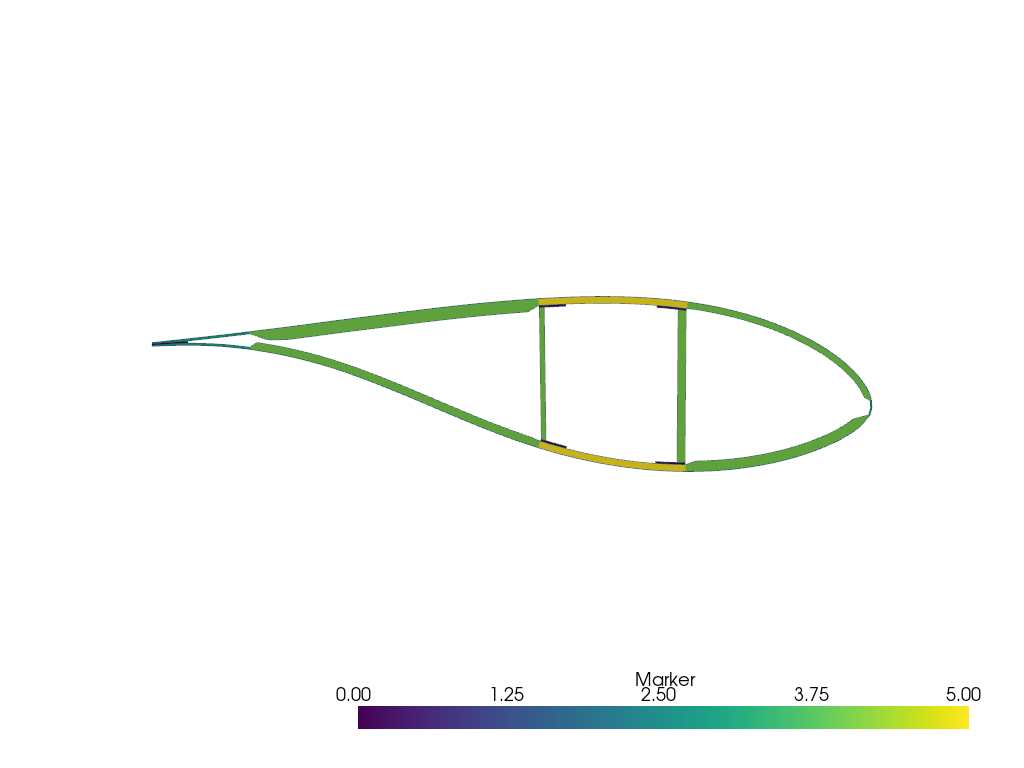

In [13]:
# Visualize plot
import pyvista
pyvista.start_xvfb()
u_topology, u_cell_types, u_geometry=dolfinx.plot.vtk_mesh(meshdata['mesh'],meshdata['mesh'].topology.dim)
grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
grid.cell_data["Marker"] = meshdata['subdomains'].values[:]
grid.set_active_scalars("Marker")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(grid)
u_plotter.view_yz() # x is beam axis
u_plotter.show()